<h1>TITEL TBD</h1>

Om nuttige voorspellingen te doen, moet eerst bepaald worden wat voorspeld moet worden. Dit document in bedoelt om later in het hoofd-document in integreren, maar is voor nu stand-alone, en dekt de Business-Understanding, Data-Understanding en (gedeeltelijk) Data-Preparation voor het target variabele af.

<h2>Target variabele.</h2>

<h3>Business understanding</h3>

Door de interviews met onze business-expert hebben begrepen dat het voorspellen van momemt van 'functieherstel' toegevoegde waarde voor ProRail zou hebben. Dit is het moment dat een traject weer klaar is om treinverkeer toe te staan. Via ProRail hebben wij dit diagram aangeleverd gekregen, wat inzicht geeft in het bedrijfsprocess:

![title](images/badkuip.png)
De X-as beslaat tijd, en de Y-as hoeveelheid treinverkeer (beiden non-proportioneel). Dit model zal naar gerefereerd worden als 'badkuip model'.

Functieherstel staat niet expliciet benoemd in dit model, maar vind plaats in de buurt van het "Storing-Eind" moment, en wanneer de lijn weer omhoog begint te bewegen op de Y-as.

ProRail baat bij een goede voorspelling wat betreft moment van functieherstel, zodat ze kunnen zorgen dat het opstarten van de dienstregeling zo goed mogelijk hierop kan aansluiten.

Uit de interviews blijkt dat de gegevens die waarschijnlijk tot een goede prognose leiden waarschijnlijk pas beschikbaar zijn wanneer een aannemer ter plekke is, in het badkuipmodel benoemd als "oplosteam aanwezig". Als het goed is zijn zowel het tijdstip van aankomst van de monteur, als het tijdstip van functieherstel aanwezig in de dataset, hoewel dit later in 'Data Understanding' bevestigd moet worden.

De verstreken tijd tussen de melding van een incident, en het moment dat een oplosteam aanwezig is is sterk variabel. Hoewel dit in de toekomst wellicht ook te voorspellen zou zijn met een model, beperken wij in onze huidige aanpak tot het voorspellen van 'aankomst aannemer' tot 'functieherstel', omdat dat volgens onze huidige business-kennis het best voorspelbaar is aan de hand van de attributen van een specifieke storing.

<h3>Data Understanding.</h3>

Om de mogelijkheid van het implementeren van het targetvariabele van (tijdstip functieherstel) - (tijdstip aankomst aannemer) te onderzoeken, moet de data geïnspecteerd om te bepalen of dit ook echt realistisch is. Hiervoor onderzoeken we de eerder benoemde hypothese voor targetvariabele, en eventuele variabelen die hier concurrentie voor zouden kunnen zijn, of meer inzicht zouden kunnen geven.

We beginnen met het importeren van een aantal libraries, en de dataset:

In [119]:
import enum

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import dummy
from sklearn import linear_model
from sklearn import model_selection
from sklearn import tree

In [51]:
df = pd.read_csv("sap_storing_data_hu_project.csv")
df

C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,...,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,2014,07/05/2014 05:30:12,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,34415,3617016,07/05/2014 05:44:24,0
1,1,50053211,0.0,NaN,02/01/2006 09:00:00,02/01/2006 09:00:00,Logboeknr Geeltje : 49 Tijd: 0900 VL-Po...,NaN,Logboeknr Geeltje : 49 Tijd: 0900,NaN,...,1,2006,02/01/2006 09:00:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,1518,12704590,13/06/2013 13:37:52,0
2,2,50053213,48.0,GN,02/01/2006 12:35:00,02/01/2006 12:35:00,Logboeknr RBV : 48 Tijd: 1235 VL-Post: ...,02/01/2006 12:35:00,Logboeknr RBV : 48 Tijd: 1235 VL-P,NaN,...,1,2006,02/01/2006 12:35:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,1518,12704591,13/06/2013 13:37:52,0
3,3,50053214,72.0,ZL,02/01/2006 16:40:00,02/01/2006 16:40:00,Logboeknr RBV : 72 Tijd: 1640 VL-Post: ...,02/01/2006 16:40:00,Logboeknr RBV : 72 Tijd: 1640 VL-P,NaN,...,1,2006,02/01/2006 16:40:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,1518,12704592,13/06/2013 13:37:52,0
4,4,50053215,96.0,ZL,02/01/2006 22:30:00,02/01/2006 22:30:00,Logboeknr RBV : 96 Tijd: 2230 VL-Post: ...,02/01/2006 22:30:00,Logboeknr RBV : 96 Tijd: 2230 VL-P,NaN,...,1,2006,02/01/2006 22:30:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,1518,12704593,13/06/2013 13:37:52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898521,908625,99003505,0.0,NaN,11/05/2013 08:06:00,11/05/2013 08:06:00,GVC : sp-2 en 3 stop lampen op de stootjukke...,NaN,GVC : sp-2 en 3 stop lampen op de stoot,NaN,...,8,2013,05/08/2013 01:00:16,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,3344,12759543,05/08/2013 01:30:37,0
898522,908626,99003506,0.0,NaN,11/05/2013 09:21:00,11/05/2013 09:21:00,Whz : Ovw 100.1 albert Plesmanweg blijft dic...,NaN,Whz : Ovw 100.1 albert Plesmanweg blijft,NaN,...,5,2013,11/05/2013 09:21:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,05/08/2013 01:00:16,0,1518,12759544,13/06/2013 13:37:52,0
898523,908627,99003506,0.0,NaN,11/05/2013 09:21:00,11/05/2013 09:21:00,Whz : Ovw 100.1 albert Plesmanweg blijft dic...,NaN,Whz : Ovw 100.1 albert Plesmanweg blijft,NaN,...,8,2013,05/08/2013 01:00:16,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1,3344,12759544,05/08/2013 01:30:37,0
898524,908628,99999999,0.0,NaN,20/08/2016 14:15:17,20/08/2016 14:15:17,Bdg-Apn : Km 12.7 twee gedode zwanen langs het...,NaN,Bdg-Apn : Km 12.7 twee gedode zwanen lan,NaN,...,8,2016,23/08/2016 06:00:19,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,24/10/2016 06:00:11,0,450213,3710373,01/09/2016 06:09:38,0


Omdat de dataset redelijk groot is, kosten veel van de operaties die tijdens het verkennen van de data gebeuren, erg veel tijd. Volgens onze business-expert zou een willikeurige selectie van ongeveer 10% van de dataset alsnog representatief voor de hele dataset moeten zijn, dus voor het verkennen maken we dit meteen aan.

In [52]:
sample = df.sample(frac=0.1, random_state=0)

Iets interessants om te onderzoeken is de relatie tussen de tijdstippen van functieherstel, storing eind, en tijdstip van melding. We maken voor de onderzoek doeleinden hier aparte variabelen van voor gemak, en kijken naar de datatypes.

In [53]:
fh_tijdstip = sample["stm_fh_ddt"]
stor_eind = sample["stm_sap_storeind_ddt"]
stm_sap_meld_ddt = sample["stm_sap_meld_ddt"]

In [54]:
print(f"""{fh_tijdstip.dtype}
{stor_eind.dtype}
{stm_sap_meld_ddt.dtype}""")

object
object
object


Al deze kolommen bestaan uit Strings. Deze moeten omgezet worden naar DateTime voor effectief rekenwerk. Hierna slaan we ze op in een apart DataFrame voor onderzoek. Uit dit dataframe verwijderen we alle rijen waar minimaal 1 NaN waarde instaat, omdat dit dataframe bedoelt is om de werking tussen de verschillende kolommen te vergelijken.

Ook definieren we een TimeDelta object voor 2 minuten, omdat het exact vergelijken van tijdstippen voor onze doelen vaak niet nuttig is, en als dingen binnen 2 minuten van elkaar vallen, dit in veel gevallen meer informatie kan geven.

In [55]:
fh_tijdstip = pd.to_datetime(fh_tijdstip, errors="coerce")
stor_eind = pd.to_datetime(stor_eind, errors="coerce")
stm_sap_meld_ddt = pd.to_datetime(stm_sap_meld_ddt, errors="coerce")

twominutes = pd.to_timedelta(2, unit="m")

In [56]:
#sample_de_1 = DataFrame DataExploration 1
df_de_1 = pd.DataFrame({"fh_ddt": fh_tijdstip,
                       "se_ddt": stor_eind,
                       "meld_ddt": stm_sap_meld_ddt}).dropna()

df_de_1.shape  # 1/3rd is dropped from nas

(66076, 3)

Een eerste vraag om te onderzoek is naar het verschil tussen "Storing eind" en "Functieherstel". Uit ons business-onderzoek begrijpen we dat deze waarschijnlijk de volgende betekenissen hebben:

Functieherstel: Het moment dat er theoretisch weer treinverkeer over het traject kan.
Storing eind: Wanneer het probleem opgelost is, en de herstelwerkzaamheden voltooid zijn.

Omdat het probleem vaak opgelost is, wanneer er weer treinen over het traject kunnen, zullen deze 2 momenten vaak tegelijk zijn. Dit kunnen we ook bevestigen:

In [57]:
def percentage(numerator: float, denominator: float) -> float:
    """Calculate a percentage from a fraction.

    Args:
        numerator: fraction numerator.
        denominator: fraction denominator.

    Returns:
        Percentage between 0 and 100, as float."""
    return (numerator / denominator) * 100


n_fh_is_se = (np.abs(df_de_1["fh_ddt"] - df_de_1["se_ddt"]) < twominutes).sum()
f"Storing Eind is in {percentage(n_fh_is_se, df_de_1.shape[0])}% van de gevallen binnen 2 minuten van Functie Herstel."

'Storing Eind is in 45.421938373993584% van de gevallen binnen 2 minuten van Functie Herstel.'

In veel andere gevallen zou men verwachten dat storing eind na functieherstel is, wanneer de aannemer het spoor weer operationeel krijgt, maar daarna wel nog werk moet afmaken.

In [58]:
n_fh_voor_se = ((df_de_1["se_ddt"] - twominutes) > df_de_1["fh_ddt"]).sum()
f"Storing eind is in {percentage(n_fh_voor_se, df_de_1.shape[0])}% van de gevallen meer dan 2 minuten na functieherstel."

'Storing eind is in 47.82220473394273% van de gevallen meer dan 2 minuten na functieherstel.'

Dit correspondeerd met de verwachting van Business Understanding.

Eerder hebben wij op basis van businesskennis een belovend targetvariabele vastgesteld, namelijk het verschil in tijd tussen het arriveren van de aannemer, en functieherstel. Om dit daadwerkelijk te kunnen gebruiken moet de daadwerkelijke data die hieraan correspondeerd geïnspecteerd worden.

In de data dictionairy staan specifiek een kolom voor datum en tijd (apart) benoemd voor het arriveren van de aannemer, namelijk "stm_aanntpl_dd" voor datum en "stm_aanntpl_tijd" voor tijd. In de dataset zit ook een kolom "stm_aanntpl_ddt", hoewel deze in de dictionairy als n.v.t. bestempeld is. Toch lijkt het nuttig het verschil tussen deze kolommen even te inspecteren, om te kijken welke van deze het beste is.

Ten eerste is het handig een beeld te hebben hoeveel NaN waardes er in deze kolommen zitten.

In [59]:
n_nan_aanntpl_dd = sample["stm_aanntpl_dd"].isna().sum()
f"De datumkolom bestaat voor {percentage(n_nan_aanntpl_dd, sample.shape[0])}% uit NaN waardes."

'De datumkolom bestaat voor 23.265778549408477% uit NaN waardes.'

In [60]:
n_nan_aanntpl_tijd = sample["stm_aanntpl_tijd"].isna().sum()
f"De tijdkolom bestaat voor {percentage(n_nan_aanntpl_tijd, sample.shape[0])}% uit NaN waardes."

'De tijdkolom bestaat voor 0.0011129288949729% uit NaN waardes.'

In [61]:
n_nan_aanntpl_ddt = sample["stm_aanntpl_ddt"].isna().sum()
f"De gecombineerde datum en tijdkolom bestaat voor {percentage(n_nan_aanntpl_dd, sample.shape[0])}% uit NaN waardes."

'De gecombineerde datum en tijdkolom bestaat voor 23.265778549408477% uit NaN waardes.'

De hoeveelheid NaN waardes komt overeen tussen de dd en ddt kolommen. Om te bevestigen dat deze gelijk zijn kunnen we de datum en tijd kolommen combineren naar één, en ze allemaal als DateTime objecten in een apart DataFrame zetten.

In [62]:
ddt_format = sample["stm_aanntpl_dd"] + " " + sample["stm_aanntpl_tijd"]

df_aan = pd.DataFrame({"t": pd.to_datetime(sample["stm_aanntpl_tijd"], errors="coerce"),
                       "d": pd.to_datetime(sample["stm_aanntpl_dd"], errors="coerce"),
                       "dt": pd.to_datetime(sample["stm_aanntpl_ddt"], errors="coerce"),
                       "dt_own": pd.to_datetime(ddt_format, errors="coerce")}).dropna()


In [63]:
f"In {percentage((df_aan['dt'] == df_aan['dt_own']).sum(), df_aan.shape[0])}% van de non-NaN gevallen is de ddt kolom gelijk aan aan de datum en tijd kolom."

'In 100.0% van de non-NaN gevallen is de ddt kolom gelijk aan aan de datum en tijd kolom.'

Al met al kunnen we dus net zo goed de ddt_tabel in de originele dataset gebruiken als targetvariabele.

Dan nog even kijken of er idd genoeg nuttige entries zijn voor functieherstel - arrival monteur

In [64]:
possible_target = df_de_1["fh_ddt"] - df_aan["dt"]  # Tijdstip functieherstel - tijdstip aankomst aannemer.
f"De mogelijke target bestaat voor {percentage(possible_target.isna().sum(), possible_target.shape[0])}% uit NaN-waardes."

'De mogelijke target bestaat voor 15.752265531171524% uit NaN-waardes.'

In [65]:
possible_target.dropna(inplace=True)
f"Wanneer deze NaN-waardes worden weggelaten hou je van de originele dataset uiteindelijk ongeveer {percentage(possible_target.shape[0], sample.shape[0])}% over die een targetvariabele hebben."

'Wanneer deze NaN-waardes worden weggelaten hou je van de originele dataset uiteindelijk ongeveer 68.70110068667714% over die een targetvariabele hebben.'

Om een nuttig targetvariabele te creeëren, zouden we uiteindelijk alle TimeDelta objecten die we gecreeërd hebben omzetten naar de hoeveelheid seconden waaruit dit tijdsinterval bestaat. Hoewel rekenen in seconden het inzicht mogelijk moeilijker maakt, verhoogt dit wel de granulariteit van het targetvariabele, waardoor deze zich meer gedraagd als continue waarde, wat de performance van het model weer ten goede komt. Om inzicht te verbeteren in performance, definieren we voor het gemak wel even een functie die een seconden-series naar minuten omzet, zodat grafieken leesbaarder gemaakt kunnen worden.

In [66]:
class TimeUnit(enum.Enum):
    """Enum that represents a unit of measurement of time, to enable easy conversion from one unit to another.

    Values for units of measurements are measured in seconds."""
    second = 1
    minute = 60
    hour = 60 * 60
    day_night_cycle = 60 * 60 * 24


def convert_timeunit(value: pd.Series or float or int,
                     from_type: TimeUnit,
                     to_type: TimeUnit) -> float:
    """Convert an amount of time as number, or a series of those, to another.

    Not class attribute of TimeUnit class to allow for better typing.

    Args:
        value:
            a number, or a series of numbers, that represent an amount of time in a certain unit of measurement as defined in
            TimeUnit.
        from_type: TimeUnit scale of measurement of time that input is in.
        to_type: TimeUnit scale of measurement of time that output should be in.

    Returns:
        Time measurement(s) converted to new unit of measurement.
        Scalar if input was scalar, array/series of input type if input was array/series."""
    coef = from_type.value / to_type.value
    return value * coef

We creeëren voor nu een apart variabele voor het targetvariabele als seconden. Deze bevat mogelijk een aantal 0-waarden, laten we deze eerst inspecteren.

In [67]:
de_target_secs = possible_target.dt.total_seconds()
f"Het targetvariabele bestaat voor {percentage((de_target_secs == 0).sum(), de_target_secs.shape[0])}% uit 0 seconden."

'Het targetvariabele bestaat voor 2.5708731572979104% uit 0 seconden.'

Het is wellicht interessant een beeld te hebben van outliers van ons targetvariabele:

{'whiskers': [<matplotlib.lines.Line2D at 0x1882d328ee0>,
 'caps': [<matplotlib.lines.Line2D at 0x18828aaf5e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1882d328b80>],
 'medians': [<matplotlib.lines.Line2D at 0x18828aafca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18824928040>],
 'means': []}

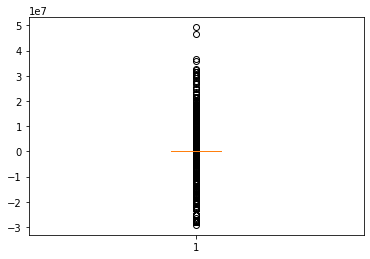

In [68]:
plt.boxplot(de_target_secs)

Uit deze bijna-onleesbare boxplot blijkt dat vooral boven de bovengrens, er heel veel extreme outliers zijn. Aan de onderkant zijn er ook een aantal negatieve waarden. Als we er vanuit gaan dat dit niet door foutive data word veroorzaakt, betekend dit waarschijnlijk dat er al weer treinen kunnen rijden, voordat er uberhaupt een monteur aan te pas komt. Hier moet wat aan gedaan worden.

Een standaardmethode om outliers te verwijderen, is de interkwartielafstand(<i>IQR</i>) berekenen, en alle waarnemingen 3IQR boven het 3e kwartiel, en 3IQR onder het eerste kwartiel te verwijderen. Het lijkt ons echter verstandiger in dit geval het verwijderen van outliers te baseren op business-kennis.

Om een nuttig voorspellend model te maken, is het waarschijnlijk handig om een ondergrens in functiehersteltijd te stellen vanaf het moment dat de aannemer komt. Omdat wij inschatten dat bij storingen onder de 5 minuten de aannemer zelf ook kan inschatten dat het heel kort gaat duren, en een voorspelling hier waarschijnlijk niet nuttig is, laten we deze weg uit onze dataset.

Onze business-expert heeft aangegeven alle hersteltijden boven de 6u niet interessant te vinden, dus deze waarnemingen laten we als NaN waarde in ons targetvariabele, en maken we een aparte binaire-categorie kolom voor, zodat dit eventueel in de toekomst nog gebruikt kan worden voor een apart model.

Om de verdelingen voor het eerste model te kunnen onderzoeken, halen we bij de data-exploration set nu alles onder 5 minuten en boven 6 uur eruit.



In [69]:
de_target_secs = de_target_secs.loc[(de_target_secs < convert_timeunit(6, TimeUnit.hour, TimeUnit.second)) & (de_target_secs > convert_timeunit(5, TimeUnit.minute, TimeUnit.second))]

<AxesSubplot:>

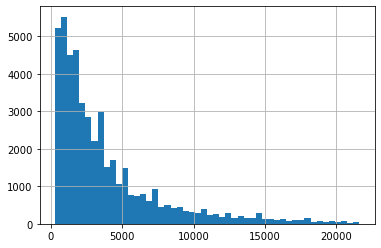

In [70]:
de_target_secs.hist(bins=50)

Ons targetvariabele lijkt exponentieel verdeeld te zijn.

<h3>Data preperation.</h3>

Nu we een idee hebben van een (hopelijk) bruikbaar target variabele, kunnen de benodigde operaties op de originele dataset uitgevoerd worden, om hieruit een volledig uitgewerkt targetvariabele voor later gebruik uit te creeëren.

We beginnen door de 2 benodigde kolommen voor het target variabele naar DateTime objecten te veranderen in nieuwe kolommen.

In [71]:
df["stm_aanntpl_ddt_as_pddt"] = pd.to_datetime(df["stm_aanntpl_ddt"], errors="coerce")
df["stm_fh_ddt_as_pddt"] = pd.to_datetime(df["stm_fh_ddt"], errors="coerce")

Hierna maken we een aparte kolom in de dataframe van het tijdstip van functieherstel, min tijdstip van arriveren van de monteur.

In [72]:
df["fh_min_aanntpl"] = df["stm_fh_ddt_as_pddt"] - df["stm_aanntpl_ddt_as_pddt"]

We slaan van deze nieuwe kolom het verschil op als seconden in een apart variabele.

In [73]:
target = df["fh_min_aanntpl"].dt.total_seconds()

We laten hieruit alles boven de 6 uur, en alles onder de 5 minuten weg, en slaan dit op in een nieuwe variabele.

In [74]:
boven_5_min = target > convert_timeunit(5, TimeUnit.minute, TimeUnit.second)
onder_6_uur = target < convert_timeunit(6, TimeUnit.hour, TimeUnit.second)

target = target.loc[boven_5_min & onder_6_uur]  # Gemeten in seconden.

target.head(5)

32099    2400.0
60682     900.0
60683     900.0
84560     319.0
84561     319.0
Name: fh_min_aanntpl, dtype: float64

<h2>Outlier removal function</h2>
Hier hebben we een functie geplaatst die outliers uit een gegeven dataframe en columns haalt.

In de comments bij deze functie staat uitgelegd hoe de functie parameters werken.

In [75]:
# TODO(m-jeu): Functiecontext/documentatie in docstring i.p.v. comments.

#wij hanteren hier de vuistregel dat waardes die 1.5IQR onder de Q1 liggen outliers OF 1.5IQR boven Q3 , outliers zijn.
#Ook hanteren wij hier de regel dat waardes die 3QR onder de Q1 liggen outliers OF 3IQR boven Q3 ,  STERKE outliers zijn.

#deze functie heeft 3 parameters:
#1e parameter: sterke van outliers die eruit worden gefilterd word. 
# 's' = strong, wat betekent dat dat alleen de sterke outliers er uit worden gefilterd.
# 'a' = all, wat betekent dat dat alle  outliers er uit worden gefilterd.
# We hebben bewust gekozen om geen optie te maken om ALLEEN de zwakke outliers weg te filteren. Dit lijkt ons niet logisch

#De 2e parameter:
# het dataframe waar de outliers worden uitgefilterd.

#De 3e parameter:
# Een lijst kolomen waar de de outliers worden uitgefilterd. bijv ['US_gross', 'duration']

#voorbeeld aanroep functie:
# column_outlier('a', df, ['US_gross', 'duration', 'budget'])


def Outlier_removal(strength, dataframe, columns):  # TODO(m-jeu): snakecase
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3  # TODO(m-jeu): Spaties om = heen
        elif strength == 'a':
            strength=1.5
    except:  # TODO(m-jeu): Implicitly exception opvangen vangt makkelijk de verkeerde exception op.
        print("Invalid strength")  # TODO(m-jeu): Crasht alsnog omdat strength welke waarde dan ook heeft die hij in functiecall heeft gekregen, waarschijnlijk character..
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]  # TODO(m-jeu): .loc voor mask operation.
    return temp_dataframe

TODO(m-jeu): Was eigenlijk mijn idee om dit te doen na de baseline.

<h3>Conversion van datetime</h3>

Hier gaan we de data uit kolom 'stm_sap_meld_ddt' bruikbaar maken voor toekomstige modellen.
Dit doen we door de datetime om te zetten naar zowel: aantal secondes vanaf middernacht & dag in het jaar

Als eerst converten we stm_sap_meld_ddt naar een pandas datetime datatype. Deze kolom krijgt de naam: 'stm_sap_meld_ddt_as_pddt'.
Op deze manier hebben we de originele data, en de omgezette data beschikbaar.

In [76]:
df['stm_sap_meld_ddt_as_pddt'] = pd.to_datetime(df["stm_sap_meld_ddt"], errors="coerce")

Nu we een kolom hebben die in het pandas datetime datatype staat, kunnen we er gemakkelijk mee werken.

We gaan hier 2 kolomen aan df toevoegen, namelijk:
- stm_sap_meld_sec_mn:  Hierin staat het aantal secondes vanaf  00:00  tot het moment van de melding
- stm_sap_meld_day_count:  Hierin staat de hoeveelste dag in dat jaar het is, op het moment van de melding

In [98]:
df['stm_sap_meld_sec_mn'] = (df['stm_sap_meld_ddt_as_pddt'] - df['stm_sap_meld_ddt_as_pddt'].dt.normalize()) / pd.Timedelta(seconds=1)
df['stm_sap_meld_day_count'] = df["stm_sap_meld_ddt_as_pddt"].dt.day_of_year

Deze kunnen samen met het targetvariabele gecombineerd worden in één DataFrame voor gebruik in model 1.

In [99]:
m1_df = pd.DataFrame({"Target": target,
                      "Tijdstip": df["stm_sap_meld_sec_mn"],
                      "Dag": df["stm_sap_meld_day_count"]})

<h3>Modelling</h3>

Met een volledig voorbereid targetvariabele, kan er een 'BaseLine' model gemaakt worden, om een RMSE score vast te stellen die overtrefd kan worden. De meest logische strategie hiervoor is het gemiddelde gokken van alle bekende waardes. Hiervoor gebruiken we van SciKitLearn de DummyRegressor, met de 'mean' strategie.

In [79]:
baseline = dummy.DummyRegressor(strategy="mean")
baseline_X = np.arange(target.shape[0])  # Dummy feature variabelen voor BaseLine.
baseline.fit(np.arange(target.shape[0]), target)

DummyRegressor()

Van dit baseline model kunnen we vervolgens de RMSE score in seconden bepalen.

In [80]:
baseline_rmse = metrics.mean_squared_error(target, baseline.predict(baseline_X), squared=False)
baseline_rmse

3904.8925801884657

Voor inzicht is het ook wel interessant deze score even in minuten te bekijken, omdat dit toch meer inzicht geeft in de business-context.

In [81]:
convert_timeunit(baseline_rmse, TimeUnit.second, TimeUnit.minute)

65.08154300314109

Dit model slaan we op in een DataFrame, waar later ook andere modellen in opgeslagen kunnen worden, zodat deze overzichtelijk bekeken kunnen worden.

In [82]:
models = pd.DataFrame({"Title": ["BaseLine model with mean strategy"],
                       "Model": [baseline],
                       "RMSE": [baseline_rmse]})

models

,Title,Model,RMSE
0,BaseLine model with mean strategy,DummyRegressor(),3904.89258


<h2>Feature variabelen: model 1</h2>

<h2>Business understanding</h2>

TODO(m-jeu): Schrijf tekst.
Blablabla feature variabelen uit interviews:

<ul>
<li>Type storing</li>
<li>Tijdstip op de dag</li>
<li>Dag in het jaar</li>
<li>Inschatting treinverkeersleider</li>
<li>Inschatting aannemer</li>
<li>Monitoringscode</li>
<li>Gebied</li>
</ul>

Per featurevariabele:

Doe hier dennis zn stukje over tijdstip op de dag, dag in het jaar.

<h2>Type storing</h2>

<h3>Data exploration</h3>

Uit ons business-onderzoek verwachten we dat het type storing waar een verlies van functie door veroorzaakt word is is van grote invloed op de tijd die het kost om functieherstel te bereiken. Attributen uit de dataset die hier wellicht invloed op kunnen hebben zijn:
<ol>
<li>stm_oorz_code: de oorzaak-code</li>
<li>stm_oorz_groep: de oorzaak-groep</li>
<li>stm_techn_mld: het techniekveld van de melding</li>
</ol>

We zullen deze kolommen onderzoeken, tot we er een vinden die relevant lijkt te zijn.

We maken van deze 3 kolommen uit de 10% subset van de dataset, en de target.

In [83]:
de_type_cols = np.array(["stm_oorz_code", "stm_oorz_groep", "stm_techn_mld"])

de_type = sample[de_type_cols].astype("category")
de_type["target"] = target
de_type.head(5)

,stm_oorz_code,stm_oorz_groep,stm_techn_mld,target
592816,218.0,TECHONV,T,2340.0
680751,149.0,ONR-DERD,E,2040.0
760628,221.0,TECHONV,T,14109.0
237571,241.0,TECHONV,B,3120.0
849077,145.0,ONR-DERD,S,2039.0


Het is handig te weten hoeveel permutaties elk variabele heeft.

In [84]:
de_type[de_type_cols].nunique()

stm_oorz_code     71
stm_oorz_groep     4
stm_techn_mld     13
dtype: int64

Om de curse of dimensionality te voorkomen is het handig zo weinig mogelijk dimensies te introduceren met het encoderen van deze categoriale variabelen. Daarom kan het handig zijn bij zo een kolom te blijven die zo weinig mogelijk permutaties heeft. We zullen deze attributen van weinig naar veel onderzoeken.

We beginnen dus bij stm_oorz_groep. Het is interessant om te weten hoe de verschillen in verdeling van het targetvariabele zijn per kolom. Hiervoor kunnen we boxplots maken per category.

<AxesSubplot:xlabel='stm_oorz_groep', ylabel='target'>

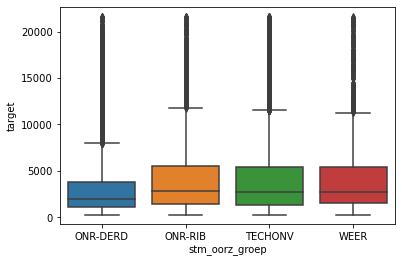

In [85]:
sns.boxplot(x=de_type["stm_oorz_groep"], y=de_type["target"])

De oorzaak groep lijkt niet veel te zeggen over het targetvariabele.

<AxesSubplot:xlabel='stm_techn_mld', ylabel='target'>

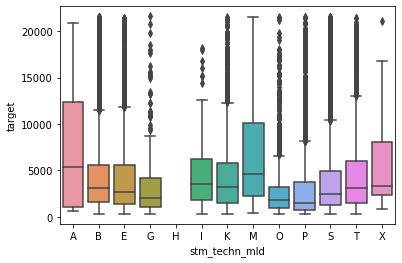

In [86]:
sns.boxplot(x=de_type["stm_techn_mld"], y=de_type["target"])

Hier lijken we al meer mee te kunnen. We dummyencoden deze en voegen hem toe aan het dataframe voor model één.

In [100]:
type_encoded = pd.get_dummies(df["stm_techn_mld"], prefix="Techniekveld")
type_encoded.head(1)

,Techniekveld_A,Techniekveld_B,Techniekveld_E,Techniekveld_G,Techniekveld_H,Techniekveld_I,Techniekveld_K,Techniekveld_M,Techniekveld_O,Techniekveld_P,Techniekveld_S,Techniekveld_T,Techniekveld_X
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [101]:
m1_df = m1_df.merge(type_encoded, left_index=True, right_index=True)
m1_df

,Target,Tijdstip,Dag,Techniekveld_A,Techniekveld_B,Techniekveld_E,Techniekveld_G,Techniekveld_H,Techniekveld_I,Techniekveld_K,Techniekveld_M,Techniekveld_O,Techniekveld_P,Techniekveld_S,Techniekveld_T,Techniekveld_X
0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,32400.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,45300.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,60000.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,81000.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898521,1440.0,29160.0,309.0,0,0,0,0,0,0,0,0,0,0,0,0,0
898522,2160.0,33660.0,309.0,0,0,0,0,0,0,0,0,0,0,1,0,0
898523,2160.0,33660.0,309.0,0,0,0,0,0,0,0,0,0,0,1,0,0
898524,1740.0,51317.0,233.0,0,0,0,0,0,0,0,0,0,0,0,0,0


Model 1 blablabla TODO(m-jeu): Tekst

In [111]:
m1_df.shape

(898526, 16)

In [112]:
m1_df.dropna(inplace=True)

In [113]:
m1_df.shape

(519888, 16)

In [114]:

X_m1 = m1_df.drop(columns="Target")
y_m1 = m1_df["Target"]

In [115]:
X_m1_train, X_m1_test, y_m1_train, y_m1_test = model_selection.train_test_split(X_m1, y_m1, random_state=0)

In [118]:
m1 = linear_model.LinearRegression()
m1.fit(X_m1_train, y_m1_train)
convert_timeunit(metrics.mean_squared_error(y_m1_test, m1.predict(X_m1_test), squared=False), TimeUnit.second, TimeUnit.minute)

64.74527529788195

In [134]:
m1_t = tree.DecisionTreeRegressor(max_depth=20)
m1_t.fit(X_m1_train, y_m1_train)
convert_timeunit(metrics.mean_squared_error(y_m1_test, m1_t.predict(X_m1_test), squared=False), TimeUnit.second, TimeUnit.minute)

64.26043563256438

In [138]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree = 3

polyreg = make_pipeline(PolynomialFeatures(degree),LinearRegression())

polyreg.fit(X_m1_train,y_m1_train)
convert_timeunit(metrics.mean_squared_error(y_m1_test, polyreg.predict(X_m1_test), squared=False), TimeUnit.second, TimeUnit.minute)

64.67803078615172